<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/GSA_final_v1_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

# Нотация фойта из тензора (3x3x3x3) в матрицу (6х6)

In [ ]:
"""Нотация Фойта - переход к матричной записи"""

def tens2mat(cij_tens, compl=False):
    """Convert from full tensor to Voigt notation
       Convert from the 3*3*3*3 elastic constants tensor to
       to 6*6 matrix representation. Recoded from the Fortran
       implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    t2m = np.array([[0,1,2,1,2,0],[0,1,2,2,0,1]])
    cij_mat = np.zeros((6,6))
    # Convert back to matrix form
    for i in range(6):
        for j in range(6):
            cij_mat[i,j] = cij_tens[t2m[0,i],t2m[1,i],t2m[0,j],t2m[1,j]]
#             cij_mat = toFixed(cij_mat[i,j], 1)
#             print(cij_mat)


    if compl:
        cij_mat = cij_mat * np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])

    return cij_mat

# print(tens2mat(C_c))
# C_cmtrx = tens2mat(C_c)

def mat2tens(cij_mat, compl=False): # cij_mat - надо задавать матрицу 6х6. compl = True - для податливости
    """Convert from Voigt to full tensor notation
       Convert from the 6*6 elastic constants matrix to
       the 3*3*3*3 tensor representation. Recoded from
       the Fortran implementation in DRex. Use the optional
       argument "compl" for the elastic compliance (not
       stiffness) tensor to deal with the multiplication
       of elements needed to keep the Voigt and full
       notation consistant.
    """
    cij_tens = np.zeros((3,3,3,3))
    m2t = np.array([[0,5,4],[5,1,3],[4,3,2]])

    if compl:
        cij_mat = cij_mat / np.array([[1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [1.0, 1.0, 1.0, 2.0, 2.0, 2.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0],
                                      [2.0, 2.0, 2.0, 4.0, 4.0, 4.0]])
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):

                    # print(m2t[i,j])
                    # print(m2t[k,l])

                    cij_tens[i,j,k,l] = cij_mat[m2t[i,j],m2t[k,l]]


    return cij_tens

# Расчет эффективного $C_{ij}$

## Initial data

In [ ]:
M_C11 = 80.
M_C12 = 8.
M_C44 = (M_C11 - M_C12)*0.5



C_mtrx = np.zeros((6,6))
C_mtrx[0,0] = C_mtrx[1,1] = C_mtrx[2,2] = M_C11
C_mtrx[0,1] = C_mtrx[0,2] = C_mtrx[1,0] = C_mtrx[1,2] =C_mtrx[2,0] = C_mtrx[2,1] = M_C12
C_mtrx[3,3] = C_mtrx[4,4] = C_mtrx[5,5] = M_C44

C_mtrx = mat2tens(C_mtrx, compl=False)
C_c = C_mtrx


k, mu = 2.25,  9.99e-17
lambda_ = k - 2 * mu / 3
c11 = lambda_ + 2 * mu
c12 = lambda_
c44 = mu

Fl_C11 = c11
Fl_C12 = c12
Fl_C44 = (Fl_C11 - Fl_C12)*0.5

C_fl = np.zeros((6, 6))
C_fl[0,0] = C_fl[1,1] = C_fl[2,2] = Fl_C11
C_fl[0,1] = C_fl[0,2] = C_fl[1,0] = C_fl[1,2] =C_fl[2,0] = C_fl[2,1] = Fl_C12
C_fl[3,3] = C_fl[4,4] = C_fl[5,5] = Fl_C44

C_fl = mat2tens(C_fl, compl=False)

In [ ]:
import numpy as np
import scipy.integrate as integrate

pi = np.pi

def tensor_g(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])



        n = n_vector.T @ n_vector

        n = n.astype(np.float64)

        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-8
    relerr = 1.0e-8
    # points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr
        }


    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):


                  integrand = (lambda θ, φ, i=i, j=j, k=k, l=l: func(θ, φ, (i, k, l, j))* np.sin(θ) + \
                                 func(θ, φ, (j, k, l, i))* np.sin(θ) +\
                                 func(θ, φ, (i, l, k, j))* np.sin(θ) +\
                                 func(θ, φ, (j, l, k, i))* np.sin(θ))

                  integral,_ = integrate.nquad(integrand, [(0, pi), (0, 2*pi)], opts=opts)

                  integrals[i, j, k, l] = integral / (-16 * pi)

    A_klnm = integrals
    return A_klnm

In [ ]:
AR = [1, 1, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 6)

NameError: name 'C_c' is not defined

In [ ]:
AR = [1000, 1000, 1]
result = tensor_g(C_c, AR)


/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


array([[-1.7000e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e-06,
         0.0000e+00,  0.0000e+00, -0.0000e+00,  6.0000e-06],
       [ 0.0000e+00, -9.0000e-06,  0.0000e+00, -9.0000e-06,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00, -6.9330e-03,  0.0000e+00, -0.0000e+00,
        -0.0000e+00, -6.9330e-03, -0.0000e+00, -0.0000e+00],
       [-0.0000e+00, -9.0000e-06,  0.0000e+00, -9.0000e-06,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00],
       [ 1.0000e-06,  0.0000e+00, -0.0000e+00,  0.0000e+00, -1.7000e-05,
        -0.0000e+00, -0.0000e+00,  0.0000e+00,  6.0000e-06],
       [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,
        -6.9330e-03, -0.0000e+00, -6.9330e-03,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00, -6.9330e-03,  0.0000e+00, -0.0000e+00,
        -0.0000e+00, -6.9330e-03, -0.0000e+00, -0.0000e+00],
       [ 0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,  0

In [ ]:
b = result.copy()
b.resize(9,9)
# np.round(b , 7)
print(b)

[[-1.72892003e-05  7.95696073e-23  3.75845464e-23  2.15384495e-23
   1.49988408e-06  3.30250261e-28  3.67299240e-23 -8.34584608e-28
   5.98431847e-06]
 [ 2.40299745e-22 -9.39454520e-06  1.80130174e-23 -9.39454520e-06
   3.28056014e-22  1.29334046e-22  1.80130174e-23  1.29334046e-22
   3.35381414e-23]
 [ 2.38865171e-23  1.80130174e-23 -6.93301291e-03  1.80130174e-23
  -2.21123258e-27 -6.68903242e-23 -6.93301291e-03 -1.42368287e-22
  -9.64735883e-23]
 [-2.08459689e-23 -9.39454520e-06  1.80130174e-23 -9.39454520e-06
   4.38298469e-22  1.29334046e-22  1.80130174e-23  1.29334046e-22
  -8.99131518e-23]
 [ 1.49988408e-06  1.60374415e-22 -3.24756162e-27  2.36161628e-22
  -1.72891939e-05 -6.07679682e-23 -3.64932447e-27  2.96380962e-23
   5.98431848e-06]
 [ 1.61752724e-27  1.29334046e-22 -9.71816290e-23  1.29334046e-22
   1.17703417e-22 -6.93301291e-03 -8.46480255e-23 -6.93301291e-03
   3.05085667e-23]
 [ 3.67299240e-23  1.80130174e-23 -6.93301291e-03  1.80130174e-23
  -1.79222187e-27 -5.3324397

In [ ]:
AR = [1000, 1000, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


KeyboardInterrupt: 

In [ ]:
AR = [100, 100, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

In [ ]:
AR = [10, 10, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

In [ ]:
AR = [1, 1, 1]
result = tensor_g(C_c, AR)
b = result.copy()
b.resize(9,9)
np.round(b , 7)

In [ ]:
C_mtrx.resize(9,9)
np.round(C_mtrx , 7)

In [ ]:
def round_func(matrix_to_change):

  matrix= np.zeros((6,6))

  for i in range(6):
    for j in range(6):

      if np.abs(matrix_to_change[i,j]) > 10**-10:
        matrix[i,j] = matrix_to_change[i,j]
  return matrix

In [ ]:
def effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

                  ### Числитель

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = round_func(tens2mat(g_m, compl=True))

  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid

  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)

  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)

  ### sum
  rslt_num = round_func((1-porosity)*num_mtrx + porosity*num_fl)


                    ### Знаменатель
  ### matrix
  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)

  ### fluid
  result_fl = (x_fl1 @ g_inv_fl1) * porosity

  ### sum
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)

        ### Effective Cij
  eff = rslt_num @ rslt_dnmntr

  print('Porosity ', porosity)
  print(np.round(round_func(eff), 5), end='\n\n')

  return eff[0,0], eff[0,2], eff[3,3], eff[2,2], eff[5,5]
  # return eff[2,2]

In [ ]:
def result_rotation_matrix(psi, phi, theta):


  B_phi = np.array(
      [[np.cos(phi), np.sin(phi), 0], ### <-- Rotation around new axis Z on phi angle
      [-np.sin(phi), np.cos(phi), 0],
      [0, 0, 1]])

  B_theta = np.array([[1, 0, 0], ### <-- Rotation around new axis N on theta angle
           [0, np.cos(theta), np.sin(theta)],
           [0, -np.sin(theta), np.cos(theta)]])

  B_psi = np.array([[np.cos(psi), np.sin(psi), 0], ### <-- Rotation around new axis N on theta angle
           [-np.sin(psi), np.cos(psi), 0],
           [0, 0, 1]])

  return np.linalg.inv(B_theta @ B_psi @ B_phi)

In [ ]:
def result_rotation_sh(theta, phi, psi, Cij, position):

  c11, c12, c44 = Cij[0], Cij[1], Cij[2]
  i,j,k,l = int(position[0]), int(position[1]), int(position[2]), int(position[3])
  # i,j = int(position[0]), int(position[1])

  c1, c2, c3 = np.cos(theta), np.cos(psi), np.cos(phi)
  s1, s2, s3 = np.sin(theta), np.sin(psi), np.sin(phi)

  l1 = c2*c3 - c1*s2*s3
  l2 = -c2*s3 - c1*s2*c3
  l3 = s1*s2

  m1 = s2*c3 + c1*c2*s3
  m2 = -s2*s3 + c1*c2*c3
  m3 = -s1*c2

  n1 = s1*s3
  n2 = s1*c3
  n3 = c1

  c = c11 - c12 - 2*c44

  c11_new = c11 - 2*c*(l1**2*m1**2 + m1**2*n1**2 + n1**2*l1**2)
  c12_new = c12 + c* (l1**2*l2**2 + m1**2*m2**2 + n1**2*n2**2)
  c44_new = c44 + c* (l2**2*l3**2 + m2**2*m3**2 + n2**2*n3**2)

  C_new = np.zeros((6, 6))
  C_new[0,0] = C_new[1, 1] = C_new[2,2] = c11_new
  C_new[0,1] = C_new[0,2] = C_new[1,0] = C_new[1,2] = C_new[2,0] = C_new[2,1] = c12_new
  C_new[3,3] = C_new[4,4] = C_new[5,5] = c44_new

  A_new = mat2tens(C_new, compl=False)

  return A_new[i,j,k,l]
  # return C_new[i,j]

In [ ]:
psi, phi, theta = np.pi/5, np.pi/6, 3*np.pi/2.5
Cij = [10, 20, 30]
a, b, c, d = 0, 1, 1, 0

position = (a, b, c, d)
print(position[0])
result_rotation_sh(theta, phi, psi, Cij, position)

0
0 1 1 0
[[25.12159595 16.716404   16.716404    0.          0.          0.        ]
 [16.716404   25.12159595 16.716404    0.          0.          0.        ]
 [ 0.         16.716404   16.716404    0.          0.          0.        ]
 [ 0.          0.          0.          6.40138924  0.          0.        ]
 [ 0.          0.          0.          0.          6.40138924  0.        ]
 [ 0.          0.          0.          0.          0.          6.40138924]]
0 1 -70 0


IndexError: index -70 is out of bounds for axis 2 with size 3

In [ ]:
c = c11-c12 - 2*c44

c11_new = c11 - 2*c*(l1**2*m1**2 + m1**2*n1**2 + n1**2*l1**2)


In [ ]:
psi, phi, theta = np.pi/5, np.pi/6, 3*np.pi/2.5

In [ ]:
A = result_rotation_sh(psi, phi, theta)
T = result_rotation_matrix(psi, phi, theta)

In [ ]:
np.isclose(A, T)

array([[False, False, False],
       [False, False, False],
       [False, False,  True]])

In [ ]:
def rotation(psi, phi, theta, C, position):

  a, b, c ,d = position[0], position[1], position[2], position[3]

  B = result_rotation_matrix(psi, phi, theta)
  B =  result_rotation_sh(psi, phi, theta)

  # print(B, end='\n\n')

  A_new = np.zeros((3, 3, 3, 3))

  # Perform the calculation for B_{p,q,m,n}
  for p in range(3):
      for q in range(3):
          for m in range(3):
              for n in range(3):

                for i in range(3):
                    for j in range(3):
                        for k in range(3):
                            for l in range(3):
                                A_new[p, q, m, n] +=  B[i,p] * B[j,q] * B[k,m] * B[l,n] * C[i, j, k, l]
  print(A_new)
  return A_new[a, b, c, d]

In [ ]:
psi, phi, theta = np.pi/5, np.pi/6, 3*np.pi/2.5
A = C_mtrx
integrand = rotation(theta, phi, psi, A, (0,1,0,1))* np.sin(theta)

[[[[ 4.45359199e+01  2.83554426e+00  6.21181845e+00]
   [ 2.83554426e+00  6.13146303e+00 -1.32750161e-01]
   [ 6.21181845e+00 -1.32750161e-01  9.10883133e+00]]

  [[ 2.83554426e+00  2.69597096e+01 -1.98162021e+00]
   [ 2.69597096e+01  3.80037288e+00  3.57532807e+00]
   [-1.98162021e+00  3.57532807e+00 -8.31680227e-02]]

  [[ 6.21181845e+00 -1.98162021e+00  3.79572807e+01]
   [-1.98162021e+00  5.52513231e-01  2.01145358e+00]
   [ 3.79572807e+01  2.01145358e+00  1.16172705e+01]]]


 [[[ 2.83554426e+00  2.69597096e+01 -1.98162021e+00]
   [ 2.69597096e+01  3.80037288e+00  3.57532807e+00]
   [-1.98162021e+00  3.57532807e+00 -8.31680227e-02]]

  [[ 6.13146303e+00  3.80037288e+00  5.52513231e-01]
   [ 3.80037288e+00  8.00000000e+01 -6.54984468e+00]
   [ 5.52513231e-01 -6.54984468e+00  1.16457492e+01]]

  [[-1.32750161e-01  3.57532807e+00  2.01145358e+00]
   [ 3.57532807e+00 -6.54984468e+00  5.05289760e+01]
   [ 2.01145358e+00  5.05289760e+01 -9.13958692e+00]]]


 [[[ 6.21181845e+00 -1.9816202

In [ ]:
integrand

-0.0

In [ ]:
from scipy import integrate

In [ ]:
def effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity):

                  ### Числитель

  ### matrix
  A_m1 = tens2mat(C_mtrx - C_c, compl=False)
  g_m1 = (tens2mat(g_m, compl=True))

  g_inv_m1 = np.linalg.inv(g_m1)
  x_m1 = np.linalg.inv(g_inv_m1 - A_m1)

  num_mtrx =  tens2mat(C_mtrx, compl=False) @ (x_m1 @ g_inv_m1) # -----> multiply in matrix form not in tensor

  ### fluid

  A_fl1 = tens2mat(C_fl - C_c, compl=False)
  g_fl1 = tens2mat(g_fl, compl=True)

  g_inv_fl1 = np.linalg.inv(g_fl1)
  x_fl1 = np.linalg.inv(g_inv_fl1 - A_fl1)

  num_fl =  tens2mat(C_fl, compl=False) @ (x_fl1 @ g_inv_fl1)

  ### sum
  rslt_num = ((1-porosity)*num_mtrx + porosity*num_fl)
  # print(rslt_num)
  # rslt_num = mat2tens(rslt_num, compl=False)


  # rslt_num_A = np.zeros((6,6))

  # for i in range(3):
  #   for j in range(3):
  #     # for k in range(3):
  #     #   for l in range(3):

  #       Cij = [rslt_num[0,0], rslt_num[0,1], rslt_num[3,3]]

  #         # integrand = (lambda theta, phi, psi, i=i, j=j, k=k, l=l: rotation(theta, phi, psi, A, (i,j,k,l))* np.sin(theta))
  #         # integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
  #         # rslt_num_A[i, j, k, l] =  integral * 1/(8*np.pi**2)
  #         # print(i,j,k,l, rslt_num_A[i, j, k, l])


  #       integrand = (lambda theta, phi, psi, i=i, j=j: result_rotation_sh(theta, phi, psi, Cij,(i,j))* np.sin(theta))
  #       integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])

  #       # Q = (lambda theta, phi, psi: np.sin(theta))
  #       # integral_Q,_ = integrate.nquad(Q, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])

  #       rslt_num_A[i, j] =  integral
  #       print(i,j, rslt_num_A[i, j])

  # Q = (lambda theta, phi, psi: np.sin(theta))
  # integral_Q,_ = integrate.nquad(Q, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
  # rslt_num_A *= integral_Q**-1
  #       ### -----------


   ### Знаменатель

  result_mtrx =  (x_m1 @ g_inv_m1) * (1-porosity)
  result_fl = (x_fl1 @ g_inv_fl1) * porosity
  rslt_dnmntr = np.linalg.inv(result_mtrx + result_fl)
  # rslt_dnmntr = mat2tens(rslt_dnmntr, compl=False)

  # rslt_dnmntr_B = np.zeros((6,6))

  # for i in range(3):
  #   for j in range(3):
  #     # for k in range(3):
  #     #   for l in range(3):

  #       A = rslt_dnmntr

  #       # integrand = (lambda psi, phi, theta, i=i, j=j, k=k, l=l: rotation(psi, phi, theta, A, (i, k, l, j))* np.sin(theta))
  #       # integral, _ = integrate.tplquad(integrand, (0, 2*np.pi), (0, 2*np.pi), (0, np.pi))

  #       Cij = [rslt_dnmntr[0,0], rslt_dnmntr[0,1], rslt_dnmntr[3,3]]


  #       integrand = (lambda theta, phi, psi, i=i, j=j: result_rotation_sh(theta, phi, psi, Cij,(i,j))* np.sin(theta))
  #       integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
  #       rslt_dnmntr_B[i, j] =  integral
  #       print(i,j, rslt_dnmntr_B[i, j])

  # Q = (lambda theta, phi, psi: np.sin(theta))
  # integral_Q,_ = integrate.nquad(Q, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
  # rslt_dnmntr_B *= integral_Q**-1




        ### Effective Cij
  # eff = rslt_num_A @ rslt_dnmntr_B
  eff = rslt_num @ rslt_dnmntr
  # print(eff)

  new_eff = np.zeros((3,3,3,3))

  for i in range(3):
    for j in range(3):
      for k in range(3):
        for l in range(3):

          A = eff

          # integrand = (lambda psi, phi, theta, i=i, j=j, k=k, l=l: rotation(psi, phi, theta, A, (i, k, l, j))* np.sin(theta))
          # integral, _ = integrate.tplquad(integrand, (0, 2*np.pi), (0, 2*np.pi), (0, np.pi))

          Cij = [A[0,0], A[0,1], A[3,3]]


          integrand = (lambda theta, phi, psi, i=i, j=j, k=k, l=l: result_rotation_sh(theta, phi, psi, Cij,(i,j,k,l))* np.sin(theta))
          integral,_ = integrate.nquad(integrand, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
          new_eff[i, j, k, l] =  integral
          # print(i,j,k,l, new_eff[i, j, k,l])

  Q = (lambda theta, phi, psi: np.sin(theta))
  integral_Q,_ = integrate.nquad(Q, [[0, np.pi], [0, 2*np.pi], [0, 2*np.pi]])
  new_eff *= integral_Q**-1


  # print('Porosity ', porosity)
  # print(np.round(round_func(eff), 5), end='\n\n')

  # return eff[0,0], eff[0,2], eff[3,3], eff[2,2], eff[5,5]
  # # return eff[2,2]

  # print(np.round(new_eff, 5))

  result = tens2mat(new_eff, compl=False)
  print(np.round(result, 5))

  return result[0,0], result[0,2], result[3,3]

In [ ]:
A = effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)

[[ 6.65058607e+01  8.03969529e+00  8.03969529e+00 -1.41705375e-17
   7.90095323e-18 -1.01632598e-16]
 [ 8.03969529e+00  6.65058607e+01  8.03969529e+00 -5.78970661e-17
   8.05985290e-19  5.16965233e-16]
 [ 8.03969529e+00  8.03969529e+00  6.65058607e+01  2.24463221e-17
  -3.74305595e-17 -4.03403287e-18]
 [-1.35537022e-17 -5.91433197e-17  2.21916114e-17  2.92330827e+01
  -2.81534998e-18 -6.09074645e-18]
 [ 9.45327969e-18  6.83657252e-18 -3.76849705e-17 -5.18586172e-17
   2.92330827e+01 -1.18366835e-17]
 [-1.30673067e-16  4.93584022e-16  1.82173359e-17 -6.02441243e-18
  -3.56967715e-17  2.92330827e+01]]
0 0 0 0 5251.092284197229
0 0 0 1 0.0
0 0 0 2 0.0
0 0 1 0 0.0
0 0 1 1 634.788896355374
0 0 1 2 0.0
0 0 2 0 0.0
0 0 2 1 0.0
0 0 2 2 634.788896355374
0 1 0 0 0.0
0 1 0 1 2308.1516939209278
0 1 0 2 0.0
0 1 1 0 2308.1516939209278
0 1 1 1 0.0
0 1 1 2 0.0
0 1 2 0 0.0
0 1 2 1 0.0
0 1 2 2 0.0
0 2 0 0 0.0
0 2 0 1 0.0
0 2 0 2 2308.1516939209278
0 2 1 0 0.0
0 2 1 1 0.0
0 2 1 2 0.0
0 2 2 0 2308.1516939

In [ ]:
A

array([[66.50586071,  8.03969529,  8.03969529,  0.        ,  0.        ,
         0.        ],
       [ 8.03969529, 66.50586071,  8.03969529,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  8.03969529,  8.03969529,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 29.23308271,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 29.23308271,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        29.23308271]])

In [ ]:
C_c = C_mtrx
g_m = tensor_g(C_c, [1, 1, 1])
g_fl = g_m
# g_fl = tensor_g(C_c, [10, 10, 1])
porosity = 0.1

In [ ]:
np.round(A, 6)

array([[ 91.150778,  -3.653538, -14.564636,   0.      ,   0.      ,
          0.      ],
       [ -2.395086,  89.892327, -14.564636,   0.      ,   0.      ,
          0.      ],
       [ -1.258451,   8.394196,  -2.516903,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      ,  23.386466,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ,  23.386466,
          0.      ],
       [  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         23.386466]])

In [ ]:
A = effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)
# print(A.shape)

KeyboardInterrupt: 

In [ ]:
np.round(A, 4)

array([[ 4.9904e+00,  4.9681e+00,  4.9681e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00],
       [ 4.9681e+00,  4.9904e+00,  4.9681e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00],
       [ 4.9681e+00,  4.9681e+00,  4.9904e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00],
       [-0.0000e+00, -0.0000e+00,  0.0000e+00,  4.2000e-03, -0.0000e+00,
        -0.0000e+00],
       [ 0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  4.2000e-03,
        -0.0000e+00],
       [-0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         4.2000e-03]])

In [ ]:
C_c = C_mtrx
g_m = tensor_g(C_c, [1, 1, 1])
g_fl = g_m
# g_fl = tensor_g(C_c, [10, 10, 1])
porosity = 0.1

KeyboardInterrupt: 

In [ ]:
np.round(result, 6)

array([[65.944951,  8.097633,  8.097633, -0.      , -0.      , -0.      ],
       [ 8.097633, 65.944951,  8.097633, -0.      ,  0.      ,  0.      ],
       [ 8.097633,  8.097633, 65.944951,  0.      ,  0.      , -0.      ],
       [-0.      , -0.      ,  0.      , 28.923659,  0.      , -0.      ],
       [-0.      ,  0.      ,  0.      , -0.      , 28.923659, -0.      ],
       [-0.      ,  0.      , -0.      , -0.      , -0.      , 28.923659]])

Aspect ratio 1 (isotropic symmetry)

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[66.50586  8.0397   8.0397   0.       0.       0.     ]
 [ 8.0397  66.50586  8.0397   0.       0.       0.     ]
 [ 8.0397   8.0397  66.50586  0.       0.       0.     ]
 [ 0.       0.       0.      29.23308  0.       0.     ]
 [ 0.       0.       0.       0.      29.23308  0.     ]
 [ 0.       0.       0.       0.       0.      29.23308]]

Porosity  0.2
[[55.09189  7.74943  7.74943  0.       0.       0.     ]
 [ 7.74943 55.09189  7.74943  0.       0.       0.     ]
 [ 7.74943  7.74943 55.09189  0.       0.       0.     ]
 [ 0.       0.       0.      23.67123  0.       0.     ]
 [ 0.       0.       0.       0.      23.67123  0.     ]
 [ 0.       0.       0.       0.       0.      23.67123]]

Porosity  0.30000000000000004
[[45.29258  7.25485  7.25485  0.       0.       0.     ]
 [ 7.25485 45.29258

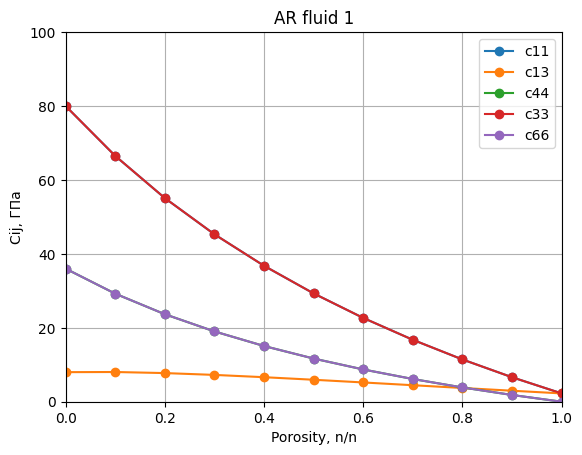

In [ ]:
c11, c13, c44, c33, c66 = [], [], [], [], []
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = g_m

for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 1')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

Aspect ratio 0.1 (VTI)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[71.92394  7.13272  3.45716  0.       0.       0.     ]
 [ 7.13272 71.92394  3.45716  0.       0.       0.     ]
 [ 3.45716  3.45716 18.27344  0.       0.       0.     ]
 [ 0.       0.       0.       0.52556  0.       0.     ]
 [ 0.       0.       0.       0.       0.52556  0.     ]
 [ 0.       0.       0.       0.       0.      32.39561]]

Porosity  0.2
[[64.14064  6.55624  2.86699  0.       0.       0.     ]
 [ 6.55624 64.14064  2.86699  0.       0.       0.     ]
 [ 2.86699  2.86699 10.29234  0.       0.       0.     ]
 [ 0.       0.       0.       0.23549  0.       0.     ]
 [ 0.       0.       0.       0.       0.23549  0.     ]
 [ 0.       0.       0.       0.       0.      28.7922 ]]

Porosity  0.30000000000000004
[[56.38557  6.00605  2.6329   0.       0.       0.     ]
 [ 6.00605 56.38557

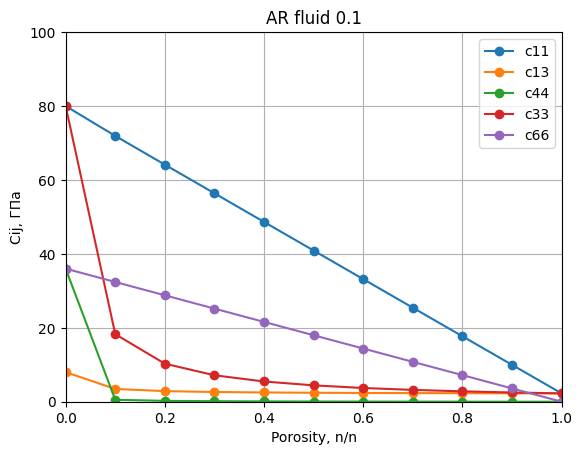

In [ ]:
c11, c13, c44, c33, c66 = [], [], [], [], []
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])

g_fl = tensor_g(C_c, [1000, 1000, 1])

for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 0.1')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]
[[49.65828 18.28263 18.28263  0.       0.       0.     ]
 [18.28263 49.65828 18.28263  0.       0.       0.     ]
 [18.28263 18.28263 49.65828  0.       0.       0.     ]
 [ 0.       0.       0.      15.68782  0.       0.     ]
 [ 0.       0.       0.       0.      15.68782  0.     ]
 [ 0.       0.       0.       0.       0.      15.68782]]
[[42.80248 17.19896 17.19896  0.       0.       0.     ]
 [17.19896 42.80248 17.19896  0.       0.       0.     ]
 [17.19896 17.19896 42.80248  0.       0.       0.     ]
 [ 0.       0.       0.      12.80176  0.       0.     ]
 [ 0.       0.       0.       0.      12.80176  0.     ]
 [ 0.       0.       0.       0.       0.      12.80176]]
[[37.19306 15.54312 15.54312  0.       0.       0.     ]
 [15.54312 37.19306 15.54312  0.       0.       0.     ]
 [15.54312 15.54312 37.19306  0.     

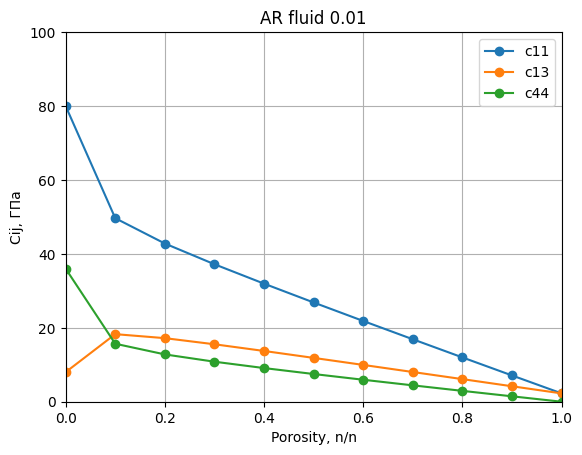

In [ ]:
c11, c13, c44 = [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = np.arange(0, 1.1, 0.1)

ar_list

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = tensor_g(C_c, [100, 100, 1])


for i in porosity:

  a, b, c =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 0.01')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

Aspect ratio 0.01 (VTI)

Porosity  0.0
[[80.  8.  8.  0.  0.  0.]
 [ 8. 80.  8.  0.  0.  0.]
 [ 8.  8. 80.  0.  0.  0.]
 [ 0.  0.  0. 36.  0.  0.]
 [ 0.  0.  0.  0. 36.  0.]
 [ 0.  0.  0.  0.  0. 36.]]

Porosity  0.1
[[71.8828   7.17036  3.84476  0.       0.       0.     ]
 [ 7.17036 71.8828   3.84476  0.       0.       0.     ]
 [ 3.84476  3.84476 20.99185  0.       0.       0.     ]
 [ 0.       0.       0.       4.57556  0.       0.     ]
 [ 0.       0.       0.       0.       4.57556  0.     ]
 [ 0.       0.       0.       0.       0.      32.35622]]

Porosity  0.2
[[64.02983  6.58529  3.17525  0.       0.       0.     ]
 [ 6.58529 64.02983  3.17525  0.       0.       0.     ]
 [ 3.17525  3.17525 11.86839  0.       0.       0.     ]
 [ 0.       0.       0.       2.18808  0.       0.     ]
 [ 0.       0.       0.       0.       2.18808  0.     ]
 [ 0.       0.       0.       0.       0.      28.72227]]

Porosity  0.30000000000000004
[[56.22392  6.02769  2.88462  0.       0.       0.     ]
 [ 6.02769 56.22392

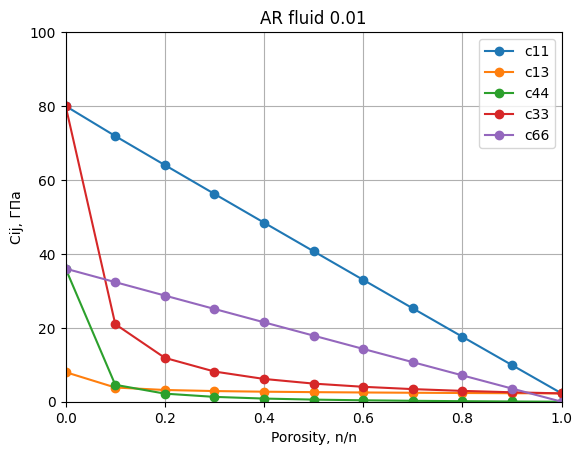

In [ ]:
c11, c13, c44, c33, c66 = [], [], [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = np.arange(0, 1.1, 0.1)

g_m = tensor_g(C_c, [1, 1, 1])
g_fl = tensor_g(C_c, [100, 100, 1])


for i in porosity:

  a, b, c, d, f =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, i)

  c11.append(a)
  c13.append(b)
  c44.append(c)
  c33.append(d)
  c66.append(f)

plt.plot(porosity, c11, label='c11', marker="o")
plt.plot(porosity, c13, label='c13', marker="o")
plt.plot(porosity, c44, label='c44', marker="o")
plt.plot(porosity, c33, label='c33', marker="o")
plt.plot(porosity, c66, label='c66', marker="o")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid 0.01')
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid()
plt.legend()

In [ ]:
np.linspace(1, 1000, 20)

array([   1.        ,   53.57894737,  106.15789474,  158.73684211,
        211.31578947,  263.89473684,  316.47368421,  369.05263158,
        421.63157895,  474.21052632,  526.78947368,  579.36842105,
        631.94736842,  684.52631579,  737.10526316,  789.68421053,
        842.26315789,  894.84210526,  947.42105263, 1000.        ])

In [ ]:
c11, c12, c44 = [], [], []
# porosity = np.arange(0.0, 1.1, 0.1)
porosity = 0.1

AR = np.linspace(1, 1000, 20)

g_m = tensor_g(C_c, [1, 1, 1])

for i in AR:

  g_fl = tensor_g(C_c, [i, i, 1])

  a, b, c =  effective_tensor_new(g_m, g_fl, C_mtrx, C_fl, C_c, porosity)

  c11.append(a)
  c12.append(b)
  c44.append(c)


[[66.50586  8.0397   8.0397   0.       0.       0.     ]
 [ 8.0397  66.50586  8.0397   0.       0.       0.     ]
 [ 8.0397   8.0397  66.50586  0.       0.       0.     ]
 [ 0.       0.       0.      29.23308  0.       0.     ]
 [ 0.       0.       0.       0.      29.23308  0.     ]
 [ 0.       0.       0.       0.       0.      29.23308]]
[[61.64855 12.18809 12.18809  0.       0.       0.     ]
 [12.18809 61.64855 12.18809  0.       0.       0.     ]
 [12.18809 12.18809 61.64855  0.       0.       0.     ]
 [ 0.       0.       0.      24.73023  0.       0.     ]
 [ 0.       0.       0.       0.      24.73023  0.     ]
 [ 0.       0.       0.       0.       0.      24.73023]]
[[49.65828 18.28263 18.28263  0.       0.       0.     ]
 [18.28263 49.65828 18.28263  0.       0.       0.     ]
 [18.28263 18.28263 49.65828  0.       0.       0.     ]
 [ 0.       0.       0.      15.68782  0.       0.     ]
 [ 0.       0.       0.       0.      15.68782  0.     ]
 [ 0.       0.       0.      

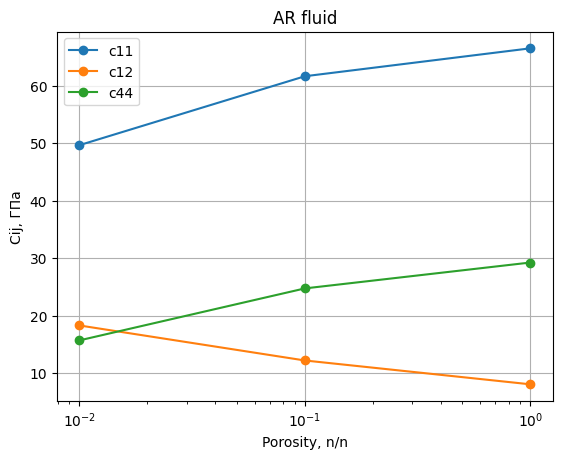

In [ ]:
AR = [1, 0.1, 0.01]

plt.plot(AR, c11, label='c11', marker="o")
plt.plot(AR, c12, label='c12', marker="o")
plt.plot(AR, c44, label='c44', marker="o")
plt.xscale("log")
plt.xlabel('Porosity, n/n')
plt.ylabel('Cij, ГПа')
plt.title ('AR fluid')

plt.grid()
plt.legend()

In [ ]:
[[66.50586  8.0397   8.0397   0.       0.       0.     ]
 [ 8.0397  66.50586  8.0397   0.       0.       0.     ]
 [ 8.0397   8.0397  66.50586  0.       0.       0.     ]
 [ 0.       0.       0.      29.23308  0.       0.     ]
 [ 0.       0.       0.       0.      29.23308  0.     ]
 [ 0.       0.       0.       0.       0.      29.23308]]
[[61.64855 12.18809 12.18809  0.       0.       0.     ]
 [12.18809 61.64855 12.18809  0.       0.       0.     ]
 [12.18809 12.18809 61.64855  0.       0.       0.     ]
 [ 0.       0.       0.      24.73023  0.       0.     ]
 [ 0.       0.       0.       0.      24.73023  0.     ]
 [ 0.       0.       0.       0.       0.      24.73023]]
[[49.65828 18.28263 18.28263  0.       0.       0.     ]
 [18.28263 49.65828 18.28263  0.       0.       0.     ]
 [18.28263 18.28263 49.65828  0.       0.       0.     ]
 [ 0.       0.       0.      15.68782  0.       0.     ]
 [ 0.       0.       0.       0.      15.68782  0.     ]
 [ 0.       0.       0.       0.       0.      15.68782]]

# BackUp

In [ ]:
def integration(C_c, ar):

  A_klnm = np.empty((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):

                # if i==j==k==l==0 or i==j==k==l==1 or i==j==k==l==2 or (i==j==0 and k==l==1) or (i==j==0 and k==l==2) or \
                #   (i==j==1 and k==l==0) or (i==j==2 and k==l==0) or \
                #   (i==j==2 and k==l==0) or (i==j==2 and k==l==1)or\
                #   (i==j==1 and k==l==2) or \
                #   (i==1 and j==2 and k==1 and l==2) or (i==2 and j==1 and k==2 and l==1) or\
                #   (i==1 and j==2 and k==2 and l==1) or (i==2 and j==1 and k==1 and l==2) or\
                #   (i==0 and j==2 and k==0 and l==2) or (i==2 and j==0 and k==2 and l==0) or\
                #   (i==2 and j==0 and  k==0 and l==2) or (i==0 and j==2 and k==2 and l==0) or\
                #   (i==0 and j==1 and k==0 and l==1) or (i==1 and j==0 and k==1 and l==0) or\
                #   (i==1 and j==0 and k==0 and l==1) or (i==0 and j==1 and k==1 and l==0):

                  A_klnm[i,j,k,l], _ = integrate.dblquad(lambda θ, φ: Function(C_c, θ, φ, ar)[i,j,k,l]*np.sin(θ), 0, 2*np.pi, \
                                                      lambda θ: 0, lambda θ: np.pi, epsabs=1.49e-8, epsrel=1.49e-8)
                  # print(i+1, j+1, k+1, l+1,  A_klnm[i,j,k,l]*(-1 /(4*np.pi)))
                # else:
                #   A_klnm[i,j,k,l] = 10***-18



  A_klnm = -1/(4*np.pi)*A_klnm

  g = np.empty((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):
                g[i,j,k,l] = (A_klnm[i,k,l,j]+A_klnm[i,l,k,j]+A_klnm[j,k,l,i]+A_klnm[j,l,k,i])*0.25

  return g

In [ ]:
import numpy as np
import scipy.integrate as integrate


def tensor_g_try(C_c, AR):

    # Define the integrand function f(θ, φ)
    def func(θ, φ, position):
        n_vector = np.array([[((np.sin(θ) * np.cos(φ))*AR[0]**-1),
                        (np.sin(θ) * np.sin(φ))*AR[1]**-1,
                        (np.cos(θ)*AR[2]**-1)]])

        n = n_vector.T @ n_vector
        λ = np.linalg.inv(np.einsum('imjn,mn->ij', C_c, n))
        return (np.einsum('mn,ij -> imjn', n, λ)*np.sin(θ))[position[0],
                                                            position[1],
                                                            position[2],
                                                            position[3]]  # Return a scalar value


    # Compute the double integral for each component of A over θ and φ
    integrals = np.zeros((3,3,3,3))

    abserr = 1.0e-10
    relerr = 1.0e-10
    points = [0,]
    opts={
        'epsabs': abserr,
        'epsrel': relerr,
        'points': points
        }

    cc_list = []

    for i in range(C_c.shape[0]):
        for j in range(C_c.shape[1]):
            for k in range(C_c.shape[2]):
                for l in range(C_c.shape[3]):

                  if (i==0 and j==0 and k==0 and l==0) or (i==0 and j==0 and k==1 and l==1) or (i==1 and j==2 and k==1 and l==2):

                    integrand = lambda θ, φ: func(θ, φ, (i,j,k,l))
                    integral,_ = integrate.nquad(integrand, [(0, np.pi), (0, 2*np.pi)],
                                                  opts=opts)

                    cc_list.append(integral*(-1/(4*np.pi)))


    return cc_list[0], cc_list[1], cc_list[2]

In [ ]:
def integration(C_c, ar):

  A_klnm = np.zeros((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):


                  A_klnm[i,j,k,l], _ = integrate.dblquad(lambda θ, φ: Function(C_c, θ, φ, ar)[i,j,k,l]*np.sin(θ), 0, 2*np.pi, \
                                                      lambda θ: 0, lambda θ: np.pi, epsabs=1.49e-8, epsrel=1.49e-8)
  A_klnm = (-1/(4*np.pi))*A_klnm

  g = np.zeros((3,3,3,3))

  for i in range(3):
      for j in range(3):
          for k in range(3):
              for l in range(3):
                g[i,j,k,l] = (A_klnm[i,k,l,j]+A_klnm[i,l,k,j]+A_klnm[j,k,l,i]+A_klnm[j,l,k,i])*0.25
  return g